In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed

import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import MinMaxScaler

import plotly
import plotly.express as px
import plotly.graph_objects as go

In [2]:
print('Tensorflow/Keras: %s' % keras.__version__)
print('pandas: %s' % pd.__version__)
print('numpy: %s' % np.__version__)
print('sklearn: %s' % sklearn.__version__)
print('plotly: %s' % plotly.__version__)

Tensorflow/Keras: 2.10.0
pandas: 1.2.4
numpy: 1.20.1
sklearn: 1.1.2
plotly: 5.4.0


# Load and Preprocess Data

In [7]:
pd.options.display.max_columns=150

df = pd.read_csv('weatherAUS.csv', encoding='utf-8', usecols=['Date', 'Location', 'MinTemp', 'MaxTemp'])

df = df[pd.isnull(df['MinTemp'])==False]
df = df[pd.isnull(df['MaxTemp'])==False]

df['Year-Month'] = (pd.to_datetime(df['Date'], yearfirst=True)).dt.strftime('%Y-%m')
df['MedTemp'] = df[['MinTemp', 'MaxTemp']].median(axis=1)

df

,Date,Location,MinTemp,MaxTemp,Year-Month,MedTemp
0,2008-12-01,Albury,13.4,22.9,2008-12,18.15
1,2008-12-02,Albury,7.4,25.1,2008-12,16.25
2,2008-12-03,Albury,12.9,25.7,2008-12,19.30
3,2008-12-04,Albury,9.2,28.0,2008-12,18.60
4,2008-12-05,Albury,17.5,32.3,2008-12,24.90
...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,2017-06,12.65
145455,2017-06-21,Uluru,2.8,23.4,2017-06,13.10
145456,2017-06-22,Uluru,3.6,25.3,2017-06,14.45
145457,2017-06-23,Uluru,5.4,26.9,2017-06,16.15


In [10]:
df2 = df[['Location', 'Year-Month', 'MedTemp']].copy()
df2 = df2.groupby(['Location', 'Year-Month'], as_index=False).mean()
df2_pivot = df2.pivot(index=['Location'], columns='Year-Month')['MedTemp']

# drop na
df2_pivot = df2_pivot.drop(['Dartmoor', 'Katherine', 'Melbourne', 'Nhil', 'Uluru'], axis=0)
df2_pivot = df2_pivot.drop(['2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06'], axis=1)

df2_pivot

Year-Month,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2013-01,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
Location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adelaide,24.967742,25.057143,20.685484,17.908333,14.324194,12.540000,12.388710,13.832258,15.026667,16.708065,24.428333,22.208065,24.737097,25.203571,21.956452,19.165000,15.106452,11.660000,11.125806,11.524194,13.071667,16.535484,19.228333,21.364516,24.467742,23.846429,19.911290,13.970968,12.521667,11.750000,13.620968,15.510000,17.570968,20.723333,22.129032,25.146774,22.686207,20.612903,18.388333,13.767742,11.573333,11.577419,11.769355,14.823333,16.943548,21.375000,23.545161,23.259677,18.551667,16.445161,12.521667,12.674194,13.162903,17.485000,16.816129,19.110000,22.043548,25.524194,23.801786,21.274194,18.163333,16.420968,12.838333,11.750000,12.087097,15.848333,19.058065,20.636667,21.188710,23.103226,25.373214,20.003226,15.785000,14.235484,12.151667,10.708065,11.988710,14.090000,20.554839,20.960345,25.285484,24.662903,22.829310,22.730645,18.708333,16.091935,12.466667,11.696774,12.696774,13.241667,15.790323,18.413333,22.025806
Albany,19.861667,20.150000,18.433871,17.461667,15.417742,13.321667,12.920968,12.988710,12.568333,15.329032,17.300000,17.864516,19.703226,20.308929,19.859677,16.978333,15.064516,13.283333,12.435484,12.838710,13.653333,15.380645,18.058333,17.925806,20.458065,20.287500,19.893548,16.233871,14.636667,12.320968,12.985484,13.843333,15.561290,17.508333,19.045161,20.425000,20.067241,19.993548,18.801786,15.741935,14.075000,13.191935,13.324194,14.241667,16.791935,17.108621,20.798333,19.081034,18.883333,15.575806,13.978333,13.253226,14.317742,14.621667,15.345161,17.705000,18.000000,20.301667,19.577778,19.277419,17.736538,16.101613,14.646667,13.205000,14.248387,15.226667,16.030645,17.093333,17.716667,20.250000,20.828571,19.143548,17.382143,14.706897,14.860000,13.290000,13.403333,14.620000,16.683333,17.585000,18.233333,20.189286,20.168966,19.660345,17.583333,14.827419,13.235000,12.891667,12.590476,12.466667,14.232759,16.489286,17.482000
Albury,25.485484,25.439286,20.535484,15.410000,11.716129,9.206667,8.201613,9.932258,11.951786,14.595161,22.803333,22.641935,25.780645,25.074000,20.775926,16.338333,11.580645,8.455000,7.874194,8.320000,11.016667,15.000000,19.258333,20.793548,24.666129,22.621429,19.366129,10.111290,8.643333,8.051613,10.150000,11.925000,15.233871,20.068333,20.800000,23.882258,22.163793,18.769355,15.668333,10.085484,8.018333,8.316129,8.567742,11.660000,14.000000,19.743333,25.629032,21.091935,15.936667,10.883333,8.833333,9.808065,10.379032,13.591667,14.295000,18.108333,22.727419,25.425806,24.946429,21.233871,16.341667,12.630645,9.943333,8.514516,8.820968,12.153704,16.606452,20.373333,22.393548,23.475806,25.000000,19.832258,15.983333,11.388710,7.848333,7.638710,8.662903,11.691667,18.975806,20.603333,23.501613,24.456452,24.329310,23.290323,17.580000,13.069355,9.500000,9.517742,9.625806,12.213333,13.617742,18.170000,22.677419
AliceSprings,29.240323,28.642857,27.470968,21.181667,14.437097,13.580000,12.933871,19.232258,22.040000,22.020968,27.345000,27.887097,28.346774,27.805357,23.753226,21.431667,15.480645,11.110000,12.153226,12.800000,16.236667,19.245161,22.210000,26.066129,29.827419,27.510714,23.345161,13.266129,10.980000,12.001613,15.219355,18.403333,23.333871,25.146667

In [12]:
# add missing data
df2_pivot['2011-04'] = (df2_pivot['2011-03'] + df2_pivot['2011-05']) / 2
df2_pivot['2012-12'] = (df2_pivot['2012-11'] + df2_pivot['2013-01']) / 2
df2_pivot['2013-02'] = (df2_pivot['2013-01'] + df2_pivot['2013-03']) / 2

# reindex
df2_pivot = df2_pivot.reindex(sorted(df2_pivot.columns), axis=1)
df2_pivot

Year-Month,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12
Location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adelaide,24.967742,25.057143,20.685484,17.908333,14.324194,12.540000,12.388710,13.832258,15.026667,16.708065,24.428333,22.208065,24.737097,25.203571,21.956452,19.165000,15.106452,11.660000,11.125806,11.524194,13.071667,16.535484,19.228333,21.364516,24.467742,23.846429,19.911290,16.941129,13.970968,12.521667,11.750000,13.620968,15.510000,17.570968,20.723333,22.129032,25.146774,22.686207,20.612903,18.388333,13.767742,11.573333,11.577419,11.769355,14.823333,16.943548,21.375000,22.460081,23.545161,23.402419,23.259677,18.551667,16.445161,12.521667,12.674194,13.162903,17.485000,16.816129,19.110000,22.043548,25.524194,23.801786,21.274194,18.163333,16.420968,12.838333,11.750000,12.087097,15.848333,19.058065,20.636667,21.188710,23.103226,25.373214,20.003226,15.785000,14.235484,12.151667,10.708065,11.988710,14.090000,20.554839,20.960345,25.285484,24.662903,22.829310,22.730645,18.708333,16.091935,12.466667,11.696774,12.696774,13.241667,15.790323,18.413333,22.025806
Albany,19.861667,20.150000,18.433871,17.461667,15.417742,13.321667,12.920968,12.988710,12.568333,15.329032,17.300000,17.864516,19.703226,20.308929,19.859677,16.978333,15.064516,13.283333,12.435484,12.838710,13.653333,15.380645,18.058333,17.925806,20.458065,20.287500,19.893548,18.063710,16.233871,14.636667,12.320968,12.985484,13.843333,15.561290,17.508333,19.045161,20.425000,20.067241,19.993548,18.801786,15.741935,14.075000,13.191935,13.324194,14.241667,16.791935,17.108621,18.953477,20.798333,19.939684,19.081034,18.883333,15.575806,13.978333,13.253226,14.317742,14.621667,15.345161,17.705000,18.000000,20.301667,19.577778,19.277419,17.736538,16.101613,14.646667,13.205000,14.248387,15.226667,16.030645,17.093333,17.716667,20.250000,20.828571,19.143548,17.382143,14.706897,14.860000,13.290000,13.403333,14.620000,16.683333,17.585000,18.233333,20.189286,20.168966,19.660345,17.583333,14.827419,13.235000,12.891667,12.590476,12.466667,14.232759,16.489286,17.482000
Albury,25.485484,25.439286,20.535484,15.410000,11.716129,9.206667,8.201613,9.932258,11.951786,14.595161,22.803333,22.641935,25.780645,25.074000,20.775926,16.338333,11.580645,8.455000,7.874194,8.320000,11.016667,15.000000,19.258333,20.793548,24.666129,22.621429,19.366129,14.738710,10.111290,8.643333,8.051613,10.150000,11.925000,15.233871,20.068333,20.800000,23.882258,22.163793,18.769355,15.668333,10.085484,8.018333,8.316129,8.567742,11.660000,14.000000,19.743333,22.686183,25.629032,23.360484,21.091935,15.936667,10.883333,8.833333,9.808065,10.379032,13.591667,14.295000,18.108333,22.727419,25.425806,24.946429,21.233871,16.341667,12.630645,9.943333,8.514516,8.820968,12.153704,16.606452,20.373333,22.393548,23.475806,25.000000,19.832258,15.983333,11.388710,7.848333,7.638710,8.662903,11.691667,18.975806,20.603333,23.501613,24.456452,24.329310,23.290323,17.580000,13.069355,9.500000,9.517742,9.625806,12.213333,13.617742,18.170000,22.677419
AliceSprings,29.240323,28.642857,27.470968,21.181667,14.437097,13.580000,12.933871,19.232258,22.040000,22.020968,27.345000,27.887097,28.346774,27.805357,23.753226,21.431667,15.480645,11.110000,12.153226,12.800000,16.236667,19.245161,22

In [79]:
df2_pivot.shape

(44, 96)

In [15]:
# plot
fig = go.Figure()
for location in df2_pivot.index:
    fig.add_trace(go.Scatter(x=df2_pivot.loc[location, :].index, 
                             y=df2_pivot.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))

fig.update_layout(dict(plot_bgcolor = 'white'), showlegend=True)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Degrees Celsius')
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))
fig.show()


# Train Model

## Feature Engineering

In [109]:
def prepare_data(data, timestep, scaler):
    for location in data.index:
        tmp_temperatures = data[data.index == location].copy()
        L = len(tmp_temperatures.columns)
        
        temperatures = tmp_temperatures.to_numpy().flatten()
        scaled_temperatures = scaler.transform(temperatures.reshape(-1, 1)).flatten()
        
        count = 0
        
        X_combination = None
        y_combination = None
        
        for month in range(0, L - (2 * timestep) + 1):
            count += 1
            X_start = month
            X_end = month + timestep
            y_start =month + timestep
            y_end = month + 2 * timestep
            
            if month == 0:
                X_combination = scaled_temperatures[X_start:X_end]
                y_combination = scaled_temperatures[y_start:y_end]
            else:
                X_combination = np.append(X_combination, scaled_temperatures[X_start:X_end])
                y_combination = np.append(y_combination, scaled_temperatures[y_start:y_end])
        
        X_location = np.reshape(X_combination, (count, timestep, 1))
        y_location = np.reshape(y_combination, (count, timestep, 1))

        if location == data.index[0]:
            X = X_location
            y = y_location
        else:
            X = np.concatenate((X, X_location), axis=0)
            y = np.concatenate((y, y_location), axis=0)
        
    return X, y  

In [110]:
timestep=18
scaler = MinMaxScaler(feature_range=(-1, 1))

In [111]:
df_train = df2_pivot.iloc[:, 0: -2 * timestep].copy()
df_test = df2_pivot.iloc[:, -2 * timestep:].copy()

In [112]:
scaler.fit(df_train.to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [113]:
X_train, y_train = prepare_data(data=df_train, timestep=timestep, scaler=scaler)
X_test, y_test = prepare_data(data=df_train, timestep=timestep, scaler=scaler)

In [114]:
X_train[0], X_train[1]

(array([[ 0.62760042],
        [ 0.63319434],
        [ 0.35965438],
        [ 0.18588473],
        [-0.0383792 ],
        [-0.15001834],
        [-0.15948476],
        [-0.0691602 ],
        [ 0.00557538],
        [ 0.11078247],
        [ 0.59384898],
        [ 0.45492409],
        [ 0.61316868],
        [ 0.64235656],
        [ 0.43918036],
        [ 0.26451588],
        [ 0.01056762],
        [-0.205081  ]]),
 array([[ 0.63319434],
        [ 0.35965438],
        [ 0.18588473],
        [-0.0383792 ],
        [-0.15001834],
        [-0.15948476],
        [-0.0691602 ],
        [ 0.00557538],
        [ 0.11078247],
        [ 0.59384898],
        [ 0.45492409],
        [ 0.61316868],
        [ 0.64235656],
        [ 0.43918036],
        [ 0.26451588],
        [ 0.01056762],
        [-0.205081  ],
        [-0.23850613]]))

In [115]:
y_train[0], y_train[1]

(array([[-0.23850613],
        [-0.21357857],
        [-0.11675132],
        [ 0.09998389],
        [ 0.26847872],
        [ 0.40214225],
        [ 0.59631482],
        [ 0.5574385 ],
        [ 0.31121216],
        [ 0.1253656 ],
        [-0.06048097],
        [-0.15116548],
        [-0.19944959],
        [-0.08238089],
        [ 0.03581813],
        [ 0.16477536],
        [ 0.36202267],
        [ 0.44997894]]),
 array([[-0.21357857],
        [-0.11675132],
        [ 0.09998389],
        [ 0.26847872],
        [ 0.40214225],
        [ 0.59631482],
        [ 0.5574385 ],
        [ 0.31121216],
        [ 0.1253656 ],
        [-0.06048097],
        [-0.15116548],
        [-0.19944959],
        [-0.08238089],
        [ 0.03581813],
        [ 0.16477536],
        [ 0.36202267],
        [ 0.44997894],
        [ 0.63880269]]))

In [116]:
X_train.shape, y_train.shape

((1100, 18, 1), (1100, 18, 1))

## Functions

In [117]:
import matplotlib.pyplot as plt

In [118]:
def plot_history(history):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()

## Build Model

In [135]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(GRU(units=128, activation='tanh', recurrent_activation='sigmoid', stateful=False)))
model.add(RepeatVector(X_train.shape[1]))
model.add(Bidirectional(GRU(units=128, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True)))
model.add(TimeDistributed(Dense(units=1, activation='linear')))

In [136]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 256)              100608    
 onal)                                                           
                                                                 
 repeat_vector_5 (RepeatVect  (None, 18, 256)          0         
 or)                                                             
                                                                 
 bidirectional_12 (Bidirecti  (None, 18, 256)          296448    
 onal)                                                           
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 1)            257       
 tributed)                                                       
                                                                 
Total params: 397,313
Trainable params: 397,313
Non-tr

In [137]:
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['MeanSquaredError', 'MeanAbsoluteError'],
    loss_weights=None,
    weighted_metrics=None,
)

In [138]:
history = model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=10,
    verbose=1,
    validation_split=0.1
)

Epoch 1/10
990/990 [==============================] - 21s 16ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.1285 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0795
Epoch 2/10
990/990 [==============================] - 16s 16ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0742 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0557
Epoch 3/10
990/990 [==============================] - 17s 17ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0725 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0567
Epoch 4/10
990/990 [==============================] - 17s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0682 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0703
Epoch 5/10
990/990 [==============================] - 17s 18ms/step - loss: 0.0082 - mea

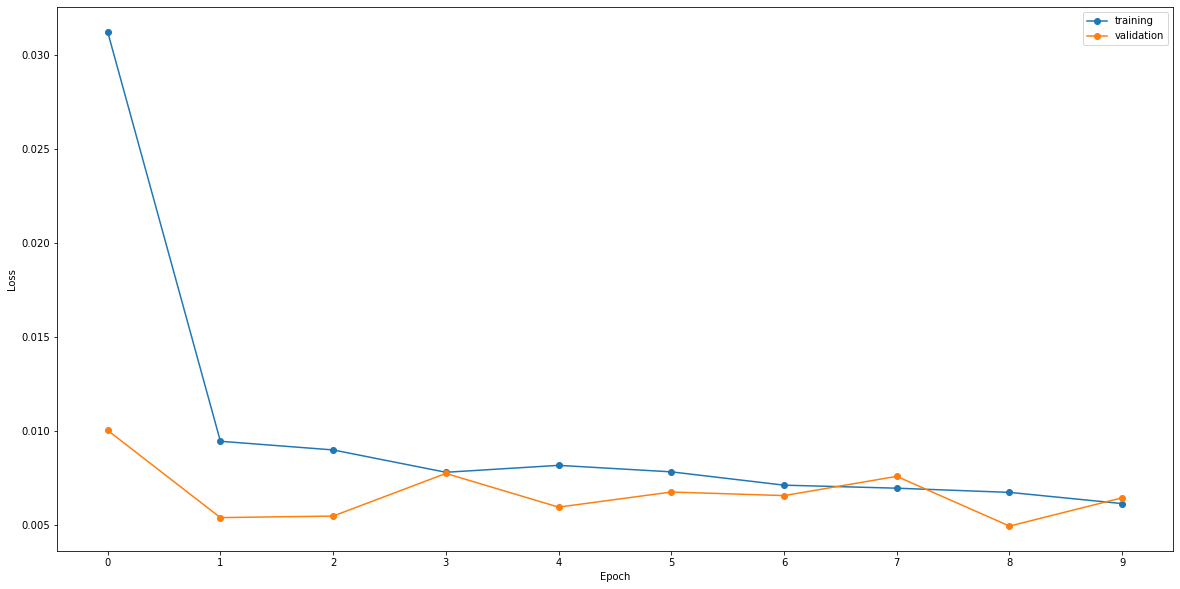

In [139]:
history = pd.DataFrame(history.history)
plot_history(history)